In [3]:
!pip install scikit-image

  Using cached tifffile-2024.8.30-py3-none-any.whl.metadata (31 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.4 MB/s eta 0:00:06
   --- ------------------------------------ 1.0/12.9 MB 2.5 MB/s eta 0:00:05
   ----- ---------------------------------- 1.8/12.9 MB 2.5 MB/s eta 0:00:05
   ------- -------------------------------- 2.4/12.9 MB 2.5 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/12.9 MB 2.6 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/12.9 MB 2.6 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.9 MB 2.6 MB/s eta 0:00:04
   ------------- -------------------------- 4.5/12.9 MB 2.6 MB/s eta 0:00:04
   --------------- ------------------------ 5.0/12.9 MB 2.6 MB/s eta 0:00:04
   ----------------- ---------------------- 5.8/12.9 MB 2.6 MB/s eta 0:00:03
   -------------------

### 1. Circle Detection using Laplacian of Gaussian

In [5]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log

# Load image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Parameters for Laplacian of Gaussian
min_sigma = 10
max_sigma = 50
num_sigma = 10
threshold = 0.1

# Blob detection using Laplacian of Gaussian
blobs = blob_log(gray_image, min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)

# Calculate radii of detected blobs
blobs[:, 2] = blobs[:, 2] * np.sqrt(2)

# Draw detected blobs
for blob in blobs:
    y, x, r = blob
    cv.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)

# Display results
cv.imshow('Detected Circles', image)
cv.waitKey(0)
cv.destroyAllWindows()

# Report largest circle and range of σ values used
largest_circle = max(blobs, key=lambda b: b[2])
print("Largest Circle: Center =", (largest_circle[1], largest_circle[0]), "Radius =", largest_circle[2])
print(f"Range of sigma values used: {min_sigma} to {max_sigma}")


Largest Circle: Center = (0.0, 113.0) Radius = 70.71067811865476
Range of sigma values used: 10 to 50


In [6]:
import numpy as np
import random

def ransac_line_fitting(points, iterations=100, threshold=1.0, min_consensus_points=50):
    best_line = None
    max_inliers = 0

    for _ in range(iterations):
        # Randomly select two points
        sample = points[np.random.choice(points.shape[0], 2, replace=False)]
        p1, p2 = sample[0], sample[1]
        
        # Calculate the line coefficients
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = np.linalg.norm([a, b])
        line = [a/d, b/d, (a*p1[0] + b*p1[1])/d]

        # Calculate the number of inliers
        distances = np.abs(line[0]*points[:, 0] + line[1]*points[:, 1] - line[2])
        inliers = points[distances < threshold]
        
        if len(inliers) > max_inliers and len(inliers) >= min_consensus_points:
            best_line = line
            max_inliers = len(inliers)

    return best_line

# Use this function to estimate the line and plot the results


In [7]:
from scipy.optimize import minimize

def ransac_circle_fitting(points, iterations=100, threshold=1.0, min_consensus_points=50):
    best_circle = None
    max_inliers = 0

    def circle_error(circle, points):
        x0, y0, r = circle
        return np.sum((np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2) - r)**2)

    for _ in range(iterations):
        sample = points[np.random.choice(points.shape[0], 3, replace=False)]
        initial_circle = [np.mean(sample[:, 0]), np.mean(sample[:, 1]), np.mean(np.linalg.norm(sample - sample.mean(axis=0), axis=1))]

        res = minimize(circle_error, initial_circle, args=(points,))
        fitted_circle = res.x
        inliers = points[np.abs(np.sqrt((points[:, 0] - fitted_circle[0])**2 + (points[:, 1] - fitted_circle[1])**2) - fitted_circle[2]) < threshold]

        if len(inliers) > max_inliers and len(inliers) >= min_consensus_points:
            best_circle = fitted_circle
            max_inliers = len(inliers)

    return best_circle

# Plot circle and line in one plot


In [10]:
!pip install tikzplotlib

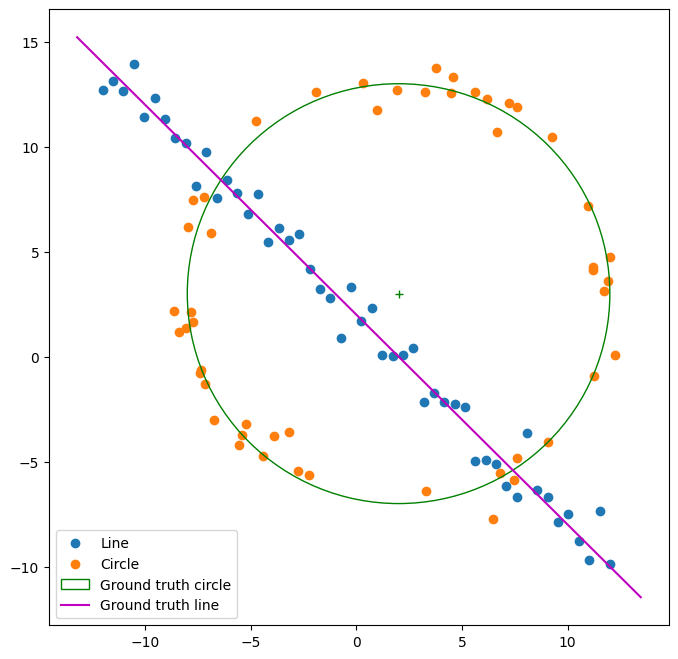

In [13]:
# Generation of a Noisy Point Set Conforming to a Line and a Ci r cl e
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N//2

r = 10
x0_gt , y0_gt = 2,3 # Center
s = r/16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig,ax = plt.subplots(1 ,1 , figsize =(8 ,8))
ax.scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'Line' )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt . Circle ( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= 'Ground truth circle' )
ax . add_patch ( circle_gt )
ax . plot ( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt . plot( x_ , y_ , color= 'm' , label='Ground truth line' )
plt . legend( )